In [11]:
import prophet
import numpy as np
import yfinance as yf
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

[*********************100%%**********************]  1 of 1 completed


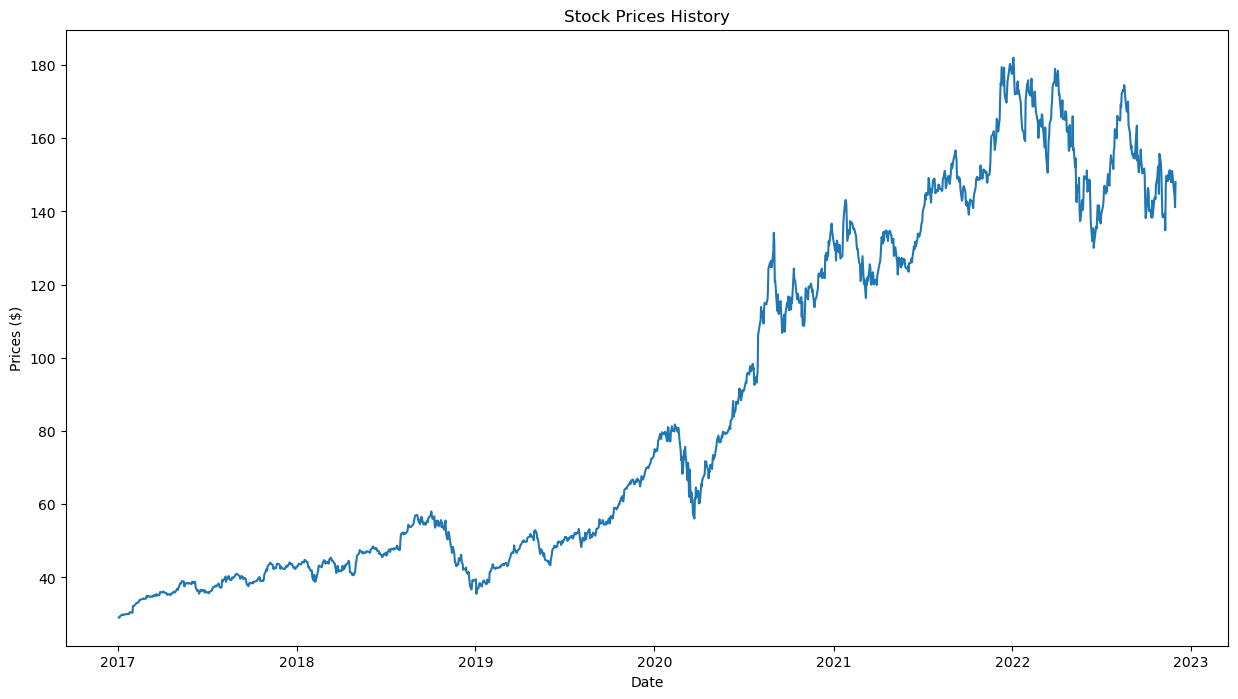

21:38:50 - cmdstanpy - INFO - Chain [1] start processing
21:38:51 - cmdstanpy - INFO - Chain [1] done processing


{'additive': ['yearly', 'weekly', 'additive_terms', 'extra_regressors_additive', 'holidays'], 'multiplicative': ['multiplicative_terms', 'extra_regressors_multiplicative']}
     Predictions      Actual
0     149.010174  145.369995
1     149.395337  141.910004
2     149.643559  142.830002
3     149.858901  141.500000
4     149.994940  142.649994
..           ...         ...
293   189.980507  151.070007
294   189.738537  148.110001
295   189.809706  144.220001
296   189.978985  141.169998
297   190.009637  148.029999

[298 rows x 2 columns]
predictionsshape (298,)


/tmp/ipykernel_11917/75964544.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions.values


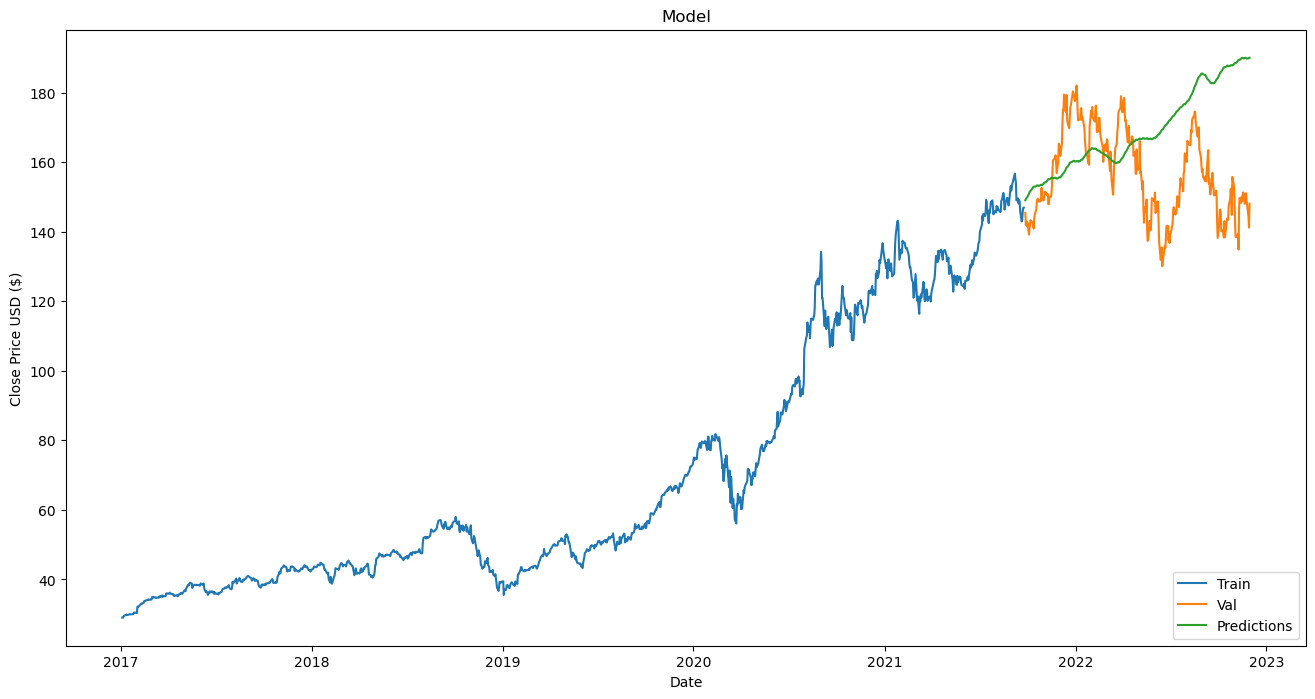

Root Mean Squared Error (RMSE): 23.093042662401256


In [12]:
class StockPricePredictor:
    def __init__(self, stock_symbol, start_date, end_date):
        self.stock_symbol = stock_symbol
        self.start_date = start_date
        self.end_date = end_date

    def download_stock_data(self):
        """Download stock data using yFinance."""
        stock_data = yf.download(self.stock_symbol, start=self.start_date, end=self.end_date)
        return stock_data

    def plot_stock_prices(self, data):
        """Plot historical prices movement of the stock."""
        plt.figure(figsize=(15, 8))
        plt.title('Stock Prices History')
        plt.plot(data['Close'])
        plt.xlabel('Date')
        plt.ylabel('Prices ($)')
        plt.show()

    def prepare_data(self, stock_data):
        """Prepare data for time series prediction."""
        # Set the 'Date' column as the feature
        stock_data_reset = stock_data.reset_index()
        df = stock_data_reset.rename(columns={'Date': 'ds', 'Close': 'y' })
                          #  'Open': 'open', 'High': 'high', 'Low': 'low', 
                           # 'Volume': 'volume', 'Adj Close': 'adj_close'})
        # Split data into training and testing sets
        train_size = int(len(df) * 0.8)
        train_data = df.iloc[:train_size]
        test_data = df.iloc[train_size:]
        y_test = df.iloc[train_size:]['y']
        
        return df,train_data,test_data,y_test

    def train_prophet_model(self, train_data):
        """Train a Prophet model."""
        model = Prophet()
        model.fit(train_data)
        print(model.component_modes)
        return model

    def evaluate_model(self, model, test_data,y_test):
        """Evaluate the Prophet model."""
        future = model.make_future_dataframe(periods=432)
        prophet_prediction = model.predict(future)
        
        # Assuming 'date' is the name of the date column in both DataFrames
        merged_data = test_data.merge(prophet_prediction[['ds', 'yhat']], on="ds", how="inner")

        # The 'yhat' column from the merged_data DataFrame now contains the values from prophet_prediction
        prediction = merged_data['yhat']
       
        
        predictions_list = prediction.tolist()
        Actual = y_test.tolist()
        df = pd.DataFrame({'Predictions': predictions_list, 'Actual': Actual})
        print(df)
        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(y_test, prediction))
        return prediction, rmse
    
    def plot_training_validation_predictions(self, stock_data, x_test, predictions):
        print("predictionsshape",predictions.shape)
        data = stock_data.filter(['Close'])
        training_data_len = len(stock_data) - len(x_test)
        train = data[:training_data_len]
        validation = data[training_data_len:]
        validation['Predictions'] = predictions.values
        plt.figure(figsize=(16, 8))
        plt.title('Model')
        plt.xlabel('Date')
        plt.ylabel('Close Price USD ($)')
        plt.plot(train)
        plt.plot(validation[['Close', 'Predictions']])
        plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
        plt.show()

    def analyze_stock(self):
        """Analyze stock prices using Prophet."""
        # Download stock data
        stock_data = self.download_stock_data()
        
        # Plot stock prices
        self.plot_stock_prices(stock_data)
        
        # Prepare data
        df,train_data,test_data,y_test = self.prepare_data(stock_data)

        # Train Prophet model
        prophet_model = self.train_prophet_model(train_data)
        
        # Evaluate model
        prediction, rmse = self.evaluate_model(prophet_model, test_data,y_test)
        
        # Create a DataFrame with the same date index as validation
        self.plot_training_validation_predictions(stock_data,test_data,prediction)
        
        return prediction, rmse
    

if __name__ == "__main__":
    stock_symbol = 'AAPL'
    start_date = '2017-01-01'
    end_date = '2022-12-01'
    stock_analyzer = StockPricePredictor(stock_symbol, start_date, end_date)
    
    predictions, rmse = stock_analyzer.analyze_stock()
    print(f"Root Mean Squared Error (RMSE): {rmse}")
